© 2025 Vanargo · Лицензия: MIT. См. файл `LICENSE` в корне репозитория.

# --- 02. Modeling: Baselines, Tuning, Evaluation --- #

**Цель ноутбука:** собрать воспроизводимый конвейер обучения для задачи 'income > 50K' на Adult (Census Income), сравнить модели, выбрать лучшую и сохранить артефакты для следующего этапа (03 - fairness & explainability).

**Содержимое:**
1. Загрузка подготовленного датасета (из 01_data_loading_and_eda.ipynb).
2. Единый препроцессор (импутация, масштабирование, OHE).
3. Модели: Logistic Regression -> Decision Tree -> Random Forest (baseline + tuning) -> XGBoost (early stopping) -> LightGBM (tuning).
4. Единая таблица метрик + визуализация.
5. Сохранение лучшей модели и артефакторв для 03 (fairness & explainability).

In [1]:
# Импорты и настройки моделинга #

import warnings, logging, os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import scipy.sparse as sp

from joblib import dump
from scipy import sparse

from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     RandomizedSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score, roc_curve,
                             auc, precision_recall_curve,
                             ConfusionMatrixDisplay, confusion_matrix,
                             )
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.calibration import calibration_curve

import lightgbm as lgb
import xgboost as xgb 
from IPython import get_ipython
from pathlib import Path
from xgboost import XGBClassifier

# тихие логгеры #
logging.getLogger('lightgbm').setLevel(logging.ERROR)
logging.getLogger('xgboost').setLevel(logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger('numba').setLevel(logging.ERROR)

# генератор случайности #
rng = np.random.default_rng(42)

# графики #
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# --- Notebook preamble: silence & style --- #

# красивые графики и кириллица без предупреждений о 'glyphs' #
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# адресные централизованные фильтры предупреждений #
warnings.filterwarnings('ignore', category=UserWarning,
                        message='.*LightGBM binary classifier.*TreeExplainer.*')
warnings.filterwarnings('ignore', category=FutureWarning,
                        message='.*Numpy global RNG was seeded.*')
warnings.filterwarnings('ignore', category=FutureWarning,
                        message='.*is_categorical_dtype is deprecated.*')
warnings.filterwarnings('ignore', category=FutureWarning,
                        message='.*pandas.*allow_gtml.*')
warnings.filterwarnings('ignore', category=UserWarning,
                        message='.*FixedFormatter should only be used with FixedLocator.*')
warnings.filterwarnings('ignore', category=UserWarning,
                        message='.*Glyph .* missing from current font.*')

# полностью скрыть DeprecationWarning #
warnings.filterwarnings('ignore', category=DeprecationWarning)

# без спама от Jupyter магии autereload #
ip = get_ipython()
if ip:
    try:
        ip.run_line_magic('load_ext', 'autoreload')
    except Exception:
        pass

In [3]:
# --- Project paths bootstrip --- #

# imports & paths #
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# предоставление Jupyter доступа к модулям из корня проекта #
ROOT = Path.cwd()
while not any((ROOT / m).exists() for m in ('.git', 'pyproject.toml', 'README.md')) and ROOT.parent != ROOT:
    ROOT = ROOT.parent

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from paths import ROOT, DATA_DIR, RAW_DIR, INT_DIR, PROC_DIR, ART_DIR, REPORTS_DIR, MODELS_DIR, NB_DIR
print(f'[paths] ROOT = {ROOT}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[paths] ROOT = C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02


# --- Data Split --- #

**Задача:** загрузить финальный датасет после EDA, сформировать 'X/y', сделать стратифицированный train/test split и задать списки признаков (*'num_features'*, *'cat_features'*).

**Важно:** все дальнейшие модели используют именно эти *'X_train/X_test/y_train/y_test',* и списки фичей.

In [4]:
# --- Загрузка EDA-датасета. Формирование X/y. train/test split --- #

# пути #
DATA_PROC_PARQUET = PROC_DIR / 'adult_eda.parquet'
DATA_PROC_CSV = PROC_DIR / 'adult_eda.csv'

# чтение (Parquet в приоритете, иначе CSV) #
if DATA_PROC_PARQUET.exists():
    df = pd.read_parquet(DATA_PROC_PARQUET)
elif DATA_PROC_CSV.exists():
    df = pd.read_csv(DATA_PROC_CSV)
else:
    raise FileNotFoundError(
        'Не найден обработанный датасет в data/processed.'
    )

# базовые проверки #
str_cols = [c for c in df.columns if df[c].dtype == 'object']
if str_cols:
    df[str_cols] = df[str_cols].apply(lambda s: s.str.strip())

# цель и признаки #
TARGET      = 'income_bin'
drop_cols   = [TARGET, 'income']

X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df[TARGET].astype(int)

# sanity-check #
assert set(np.unique(y)).issubset({0, 1}), 'y должен быть бинарным (0/1)'
print('Форма полного набора:', X.shape, '| Классы:', y.value_counts(normalize=True).round(3).to_dict())

# стратифицированный сплит #
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# список числовых/категориальных фич для препроцессинга #
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# обеспечение категориального типа для биннинга возраста #
for df_ in (X_train, X_test):
    if 'age_group' in df_.columns:
        df_.loc[:, 'age_group'] = df_['age_group'].astype('category')

print(
    f'train: {X_train.shape}, test: {X_test.shape} | '
    f'pos_rate train={y_train.mean():.3f}, test={y_test.mean():.3f}'
)
print('num_features:', len(num_features), '| cat_features:', len(cat_features))

Форма полного набора: (48842, 18) | Классы: {0: 0.761, 1: 0.239}
train: (39073, 18), test: (9769, 18) | pos_rate train=0.239, test=0.239
num_features: 9 | cat_features: 9


# --- Unified Preprocessing --- #

**Идея:** один общий *'ColumnTransformer'* для всех моделей:
1. **Числовые:** *"SimpleImputer(strategy='median')"* -> *'StandartScaler()'*.
2. **Категориальные:** *"SimpleImputer(strategy='most_frequent')"* -> *"OneHotEncoder(handle_unknown='ignore')"*.

Так мы гарантируем согласованность подготовки данных между моделями.

In [5]:
# --- Базовый препроцессор (ColumnTransformer) для всех моделей --- #

# числовой контейнер: median impute -> scale #
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# категориальный конвейер: fill 'Unknown' -> OHE #
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

preprocessor.set_output(transform='pandas')

print(f'Числовые: {len(num_features)} | Категориальные: {len(cat_features)}')

Числовые: 9 | Категориальные: 9


In [6]:
# --- Вспомогательные функции: метрики и логирование --- #

def evaluate_model(model, X_tr, y_tr, X_te, y_te, name: str):
    """Возвращает dict с единым набором метрик"""
    # вероятности для AUC (если есть predict_proba) #
    if hasattr(model, 'predict_proba'):
        y_proba_te = model.predict_proba(X_te)[:, 1]
    else:
        # fallback: решения некоторых моделей #
        try:
            y_proba_te = model.decision_function(X_te)
        except Exception:
            y_proba_te = None
    
    y_pred_te = model.predict(X_te)

    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_te,   y_pred_te),
        'precision': precision_score(y_te,  y_pred_te,  zero_division=0),
        'recall': recall_score(y_te,        y_pred_te,  zero_division=0),
        'f1': f1_score(y_te,                y_pred_te,  zero_division=0),
        'auc': roc_auc_score(y_te,          y_proba_te) if y_proba_te is not None else np.nan,
    }
    return metrics

In [7]:
# --- инициализация хранилища результатов --- #
results = []

# --- Raw Copies for Analysis --- #

Делаем копии "сырых" фичей (*'X_train_raw'*, *'X_test_raw'*) **до** конвейера. Это поможет при анализе ошибок/кейсов и при интерпретации в 03 - fairness & explainability (например, для групповых разрезов).

In [8]:
# --- Создание raw-тестового набора и raw-тренировочного наборов --- #

# копирование 'сырых' фич до конвейера (для интерпретации и анализа ошибок) #
X_test_raw = X_test.copy()
X_train_raw = X_train.copy()

# age_group имеет категориальный тип #
for df_ in (X_train_raw, X_test_raw):
    if 'age_group' in df_.columns:
        df_['age_group'] = df_['age_group'].astype('category')

print(f'Сырые данные: train_raw {X_train_raw.shape}, test_raw {X_test_raw.shape}')

Сырые данные: train_raw (39073, 18), test_raw (9769, 18)


# --- Logistic Regression --- #

Минимальный сильный baseline. Дает ориентир по качеству, обучается быстро, хорошо читает линейные зависимости.

In [9]:
# --- Logistic Regression (baseline) --- #

pipe_lr = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf',     LogisticRegression(
        solver='lbfgs',
        max_iter=2000,
        random_state=42,
        n_jobs=-1 if 'n_jobs' in LogisticRegression().get_params() else None
    ))
])

pipe_lr.fit(X_train, y_train)
metrics_lr = evaluate_model(pipe_lr, X_train, y_train, X_test, y_test, 'LogReg')
results.append(metrics_lr)
metrics_lr

{'model': 'LogReg',
 'accuracy': 0.8554611526256526,
 'precision': 0.740894901144641,
 'recall': 0.6090675791274593,
 'f1': 0.6685446009389672,
 'auc': 0.9115962089316954}

# --- Decision Tree --- #

Показываем разницу Gini vs Entropy и фиксируем качество одиночного дерева. Полезно как интерпретируемый ориентир.

In [10]:
# --- Decision Tree: Gini vs Entropy --- #

for crit in ['gini', 'entropy']:
    pipe_dt = Pipeline(steps=[
        ('preproc', preprocessor),
        ('clf',     DecisionTreeClassifier(
            criterion=crit,
            max_depth=None,
            random_state=42
        ))
    ])
    pipe_dt.fit(X_train, y_train)
    results.append(evaluate_model(pipe_dt, X_train, y_train, X_test, y_test,
                                  f'DT_{crit}'))
results[-2:]

[{'model': 'DT_gini',
  'accuracy': 0.8135940219060293,
  'precision': 0.6086591004623791,
  'recall': 0.6193327630453379,
  'f1': 0.6139495442018232,
  'auc': 0.7473975286062052},
 {'model': 'DT_entropy',
  'accuracy': 0.8182004299314157,
  'precision': 0.6189669771380186,
  'recall': 0.6253207869974337,
  'f1': 0.6221276595744681,
  'auc': 0.7524539708863028}]

# --- Random Forest --- #

Сначала baseline, затем легкий *'RandomizedSearch'* по ключевым гиперпараметрам. Все варианты используют **единый** препроцессор.

In [11]:
# --- Random Forest: baseline --- #

pipe_rf = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf',     RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])
pipe_rf.fit(X_train, y_train)
results.append(evaluate_model(pipe_rf, X_train, y_train, X_test, y_test,
                              'RF_baseline'))
results[-1]

{'model': 'RF_baseline',
 'accuracy': 0.8558706111167981,
 'precision': 0.733433734939759,
 'recall': 0.6248930710008554,
 'f1': 0.6748267898383372,
 'auc': 0.9086162124105213}

In [12]:
# --- Random Forest: hyperparameter searh --- #

rf_param_dist = {
    'clf__n_estimators': [200, 400, 800],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2', 0.5, 0.8]
}

pipe_rf_tune = Pipeline(steps=[
    ('prepr', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_search = RandomizedSearchCV(
    estimator=pipe_rf_tune,
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=0,
    random_state=42,
    error_score=np.nan
)
rf_search.fit(X_train, y_train)
print('RF best params:', rf_search.best_params_,
      '\nRF best CV AUC:', round(rf_search.best_score_, 4))

rf_best = rf_search.best_estimator_
results.append(evaluate_model(rf_best, X_train, y_train, X_test, y_test,
                              'RF_best'))

RF best params: {'clf__n_estimators': 400, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 20} 
RF best CV AUC: 0.9191


# --- XGBoost (Early Stopping) --- #

Валидируем только на подвыборке из train. **Fit** препроцессора - на *'X_tr'*, далее только *'transform'* для *'X_val'* / *'X_test'*. Это исключает рассинхрон признаков.

In [13]:
# --- XGBoost: early stopping --- #

# валид.сплит из train #
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

X_tr_enc =      preprocessor.fit_transform(X_tr)
X_val_enc =     preprocessor.transform(X_val)
X_te_enc =      preprocessor.transform(X_test)

# sanity-check #
assert X_tr_enc.shape[1] == X_val_enc.shape[1] == X_te_enc.shape[1], \
    f'Dim mismatch: train={X_tr_enc.shape[1]}, val={X_val_enc.shape[1]}, test={X_te_enc.shape[1]}'

# DMatrix #
dtr = xgb.DMatrix(X_tr_enc,     label=y_tr)
dval = xgb.DMatrix(X_val_enc,   label=y_val)
dte = xgb.DMatrix(X_te_enc)

# параметры XGBoost #
params = {
    'objective':        'binary:logistic',
    'eval_metric':      'auc',
    'verbosity':        0,
    'eta':              0.05,
    'max_depth':        6,
    'subsample':        0.9,
    'colsample_bytree': 0.9,
    'seed':             42,
    'tree_method':      'hist'
}

evals = [(dtr, 'train'), (dval, 'val')]

# тренировка с ранней остановкой early stopping #
bst = xgb.train(
    params=params,
    dtrain=dtr,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False
)

print('Best iteration:',    bst.best_iteration)
print('Best val AUC:',      bst.best_score)

y_proba_xgb = bst.predict(dte, iteration_range=(0, bst.best_iteration + 1))

Best iteration: 365
Best val AUC: 0.9312022415817004


In [14]:
# --- Логирование метрик XGB --- #

y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)
metrics_xgb = {
    'model': 'XGB_es',
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb, zero_division=0),
    'recall': recall_score(y_test, y_pred_xgb, zero_division=0),
    'f1': f1_score(y_test, y_pred_xgb, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba_xgb)
}
results.append(metrics_xgb)
metrics_xgb

{'model': 'XGB_es',
 'accuracy': 0.8792097451120893,
 'precision': 0.7951070336391437,
 'recall': 0.6672369546621043,
 'f1': 0.7255813953488373,
 'auc': 0.9310527972257803}

# --- LightGBM (RandomizedSearch) --- #

Быстрый перебор по деревьям с использованием единого препроцессора. Метрика - ROC AUC.

In [15]:
# --- LightGBM: RandomizedSearch --- #

pipe_lgb = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', lgb.LGBMClassifier(
        objective='binary',
        random_state=42,
        n_estimators=500,
        verbosity=-1
    ))
])

param_dist_lgb = {
    'clf__num_leaves':          [31, 63, 127, 255],
    'clf__max_depth':           [-1, 5, 10, 20],
    'clf__learning_rate':       [0.01, 0.05, 0.1],
    'clf__subsample':           [0.7, 0.85, 1.0],
    'clf__colsample_bytree':    [0.7, 0.85, 1.0],
    'clf__min_child_samples':   [10, 20, 50, 100]
}

lgb_search = RandomizedSearchCV(
    estimator=pipe_lgb,
    param_distributions=param_dist_lgb,
    n_iter=25,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=0,
    random_state=42,
    error_score=np.nan
)

lgb_search.fit(X_train, y_train)
print('LGB best params:', lgb_search.best_params_, '\nLGB best CV AUC:', round(lgb_search.best_score_, 4))

lgb_best = lgb_search.best_estimator_
results.append(evaluate_model(lgb_best, X_train, y_train, X_test, y_test,
                              'LGBM_best'))

LGB best params: {'clf__subsample': 1.0, 'clf__num_leaves': 31, 'clf__min_child_samples': 20, 'clf__max_depth': 5, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.7} 
LGB best CV AUC: 0.9292


In [16]:
# --- Разрыв train vs test для LGBM --- #

# AUC на train #
train_proba = lgb_best.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, train_proba)

# AUC на test #
test_proba = lgb_best.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, test_proba)

print(f'LGBM train AUC: {auc_train:.4f}')
print(f'LGBM test AUC: {auc_test:.4f}')
print(f'Разрыв (train - test): {auc_train - auc_test:+.4f}')

LGBM train AUC: 0.9458
LGBM test AUC: 0.9321
Разрыв (train - test): +0.0136


# --- Unified Metrics Table --- #

Все модели сводим в единый *'results_df'* (AUC, F1, Precision, Recall, Accuracy), сортируем по AUC/F1 и выбираем победителя.

In [17]:
# --- Метрики и сводная таблица результатов --- #

results_df = pd.DataFrame(results)
results_df = results_df[['model', 'auc', 'f1', 'precision', 'recall',
                         'accuracy']]
results_df.sort_values(by=['auc', 'f1'], ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df

,model,auc,f1,precision,recall,accuracy
0,LGBM_best,0.932137,0.723792,0.796915,0.662960,0.878903
1,XGB_es,0.931053,0.725581,0.795107,0.667237,0.879210
2,RF_best,0.921436,0.683694,0.802768,0.595381,0.868154
3,LogReg,0.911596,0.668545,0.740895,0.609068,0.855461
4,RF_baseline,0.908616,0.674827,0.733434,0.624893,0.855871
5,DT_entropy,0.752454,0.622128,0.618967,0.625321,0.818200
6,DT_gini,0.747398,0.613950,0.608659,0.619333,0.813594


# --- Model Comparison Chart --- #

Быстрый бар-чарт по ключевым метрикам  (AUC, F1, Accuracy) для визуального сравнения.

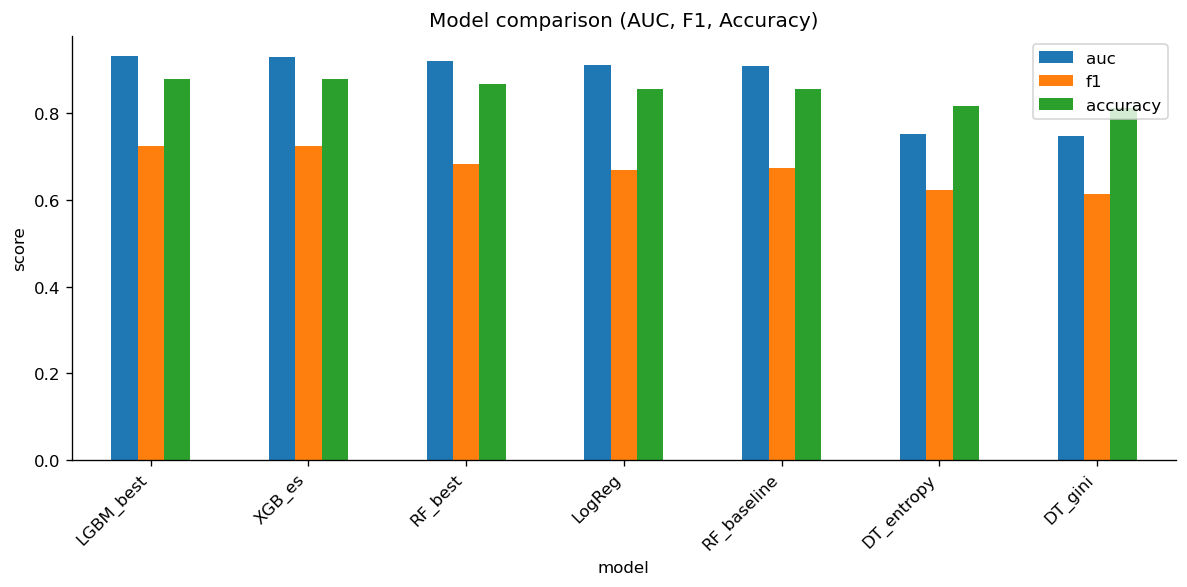

In [18]:
# --- Визуализация сравнения моделей --- #

ax = results_df.set_index('model')[['auc', 'f1', 'accuracy']].plot(kind='bar',
                                                                   figsize=(10,5))
ax.set_ylabel('score')
ax.set_title('Model comparison (AUC, F1, Accuracy)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Saving Best Model & Artifacts --- #

Сохраняем лучшую модель и артефакты, чтобы в 03 (fairness & explainability) можно было:
1. Загрузить модель.
2. Получить предсказания/скоринги.
3. Сделать fairness-анализ и интерпретацию.

In [19]:
# --- Сохранение лучшей модели --- #

MODELS_DIR.mkdir(parents=True, exist_ok=True)

best_row = results_df.iloc[0]
best_name = best_row['model']
print('Лучший по AUC/F1:', best_name)

# соответствующий объект #
name2obj = {
    'LogReg': pipe_lr,
    'DT_gini': None,
    'DT_entropy': None,
    'RF_baseline': pipe_rf,
    'RF_best': rf_best,
    'XGB_es': bst,
    'LGBM_best': lgb_best,
}

obj = name2obj.get(best_name)
if obj is not None and best_name != 'XGB_es':
    dump(obj, MODELS_DIR / f'{best_name}.joblib')
    print('Сохранено:', MODELS_DIR / f'{best_name}.joblib')
elif best_name == 'XGB_es':
    bst.save_model(str(MODELS_DIR / 'XGB_es.json'))
    print('Сохранено', MODELS_DIR / 'XGB_es.json')
else:
    print('Добавь объект модели в name2obj перед сохранением.')

Лучший по AUC/F1: LGBM_best
Сохранено: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\models\LGBM_best.joblib


# --- Export Artifacts for 03 (fairness & explainability) --- #

Сохраняем все, что понадобится в следующем ноутбуке:
1. *'results_fd'* - сводная таблица по моделям.
2. *'y_true_test'*, *'y_proba_test'*, *'y_pred_test'* - истинные и предсказанные значения на тесте.
3. *'y_test_raw'* с чувствительными признаками (*'sex'*, *'race'*, *'age_group'*, *'education'*,,и т.д.)
4. Технические артефакты: лучшая модель, препроцессор, имена фич после OHE.

In [ ]:
# --- Экспорт артефактов --- #

# сохранение сводной таблицы метрик #
assert 'results_df' in globals(), 'results_df не найден. Сначала сформируйте таблицу метрик.'
results_df.to_csv(ART_DIR / 'results_df.csv', index=False)

# определить лучшую модель по AUC, затем F1 #
best_row = results_df.sort_values(['auc', 'f1'], ascending=False).iloc[0]
best_name = best_row['model']
print('Лучший по метрикам: ', best_name)

# y_true #
assert 'y_test' in globals(), 'y_test не найден.'
y_true_test = np.asarray(y_test, dtype='int8')

# заглушки #
y_proba_best: np.ndarray | None = None
y_pred_best:  np.ndarray | None = None
feature_names = None
X_test_enc = None
preproc_fitted = None

# универсальный поиск preprocessor и имty признаков #
def _find_preprocessor_from_pipeline(pipe):
    if not hasattr(pipe, 'named_steps'):
        return None
    for key in ['preproc', 'prep', 'transformer', 'ct']:
        if key in pipe.named_steps:
            return pipe.named_steps[key]
    return None

candidate_pipes = []
for nm in ['model_best', 'pipe_lr', 'pipe_rf', 'pipe_xgb']:
    if nm in globals() and getattr(globals()[nm], 'named_steps', None):
        candidate_pipes.append(globals()[nm])

# попытка достать preprocessor из любого доступного pipeline #
for p in candidate_pipes:
    preproc_fitted = _find_preprocessor_from_pipeline(p)
    if preproc_fitted is not None:
        break

# получение вероятностей/предсказаний лучшей модели #
assert 'X_train' in globals() and 'X_test' in globals() and 'y_train' in globals(), \
    'Нужны X_train, X_test, y_train.'

if best_name == 'XGB_es':
    # XGBoost с ранней остановкой - ожидается booster bst
    if 'bst' not in globals():
        raise RuntimeError('Booster "bst" не найден. Выполните ячейку с XGBoost (early stopping).')

    # для стабильности 03_fairness_and_explainability.ipynb:
    # кодирование X_test, если есть preprocessor
    try:
        if preproc_fitted is None and 'model_best' in globals():
            preproc_fitted = _find_preprocessor_from_pipeline(model_best)
        if preproc_fitted is not None:
            preproc_fitted = preproc_fitted.fit(X_train, y_train)  # зафиксируем состояние
            X_test_enc = preproc_fitted.transform(X_test)
    except Exception as e:
        print("[warn] Не удалось получить X_test_enc для XGB_es:", e)

    # Если есть закодированный X — используем его; иначе пробуем сырые (если обучали так же)
    try:
        import xgboost as xgb
        if X_test_enc is not None:
            dte = xgb.DMatrix(X_test_enc)
        else:
            dte = xgb.DMatrix(X_test)
        y_proba_best = bst.predict(dte, iteration_range=(0, bst.best_iteration + 1))
        y_pred_best = (y_proba_best >= 0.5).astype('int8')
    except Exception as e:
        raise RuntimeError(f'Ошибка предсказания XGB_es: {e}')

else:
    # -------------------------------
    # Фрагмент 4 — маппинг моделей для best_name (добавь сюда реально обученные в ноутбуке объекты)
    # -------------------------------
    name2obj = {
        'LogReg'     : globals().get('pipe_lr'),
        'DT_gini'    : None,      # чистое дерево обычно не сохраняем/не используем для финала
        'DT_entropy' : None,
        'RF_baseline': globals().get('pipe_rf'),
        'RF_best'    : globals().get('rf_best'),
        'LGBM_best'  : globals().get('lgb_best'),
        'XGB_es'     : None,      # для XGB_es выше отдельная ветка
    }
    best_model = name2obj.get(best_name)
    if best_model is None:
        raise RuntimeError(
            f'Нет обученного объекта модели для "{best_name}". '
            f'Убедитесь, что соответствующая ячейка обучения выполнена и добавьте её в name2obj.'
        )

    # Вероятности/decision_function (работает и для Pipeline, и для чистого эстиматора)
    if hasattr(best_model, 'predict_proba'):
        y_proba_best = best_model.predict_proba(X_test)[:, 1]
    else:
        if hasattr(best_model, 'decision_function'):
            y_proba_best = best_model.decision_function(X_test)
        else:
            raise RuntimeError(f'Модель "{best_name}" не предоставляет вероятности/decision_function.')

    y_pred_best = (y_proba_best >= 0.5).astype('int8')

    # -------------------------------
    # Фиксация препроцессора и подготовка X_test_enc (универсально)
    # -------------------------------
    # если best_model — это Pipeline, попробуем достать из него препроцессор
    if getattr(best_model, "named_steps", None):
        preproc_fitted = _find_preprocessor_from_pipeline(best_model)
    # если не нашли, используем ранее найденный из candidate_pipes
    if preproc_fitted is None:
        preproc_fitted = None
        for p in candidate_pipes:
            preproc_fitted = _find_preprocessor_from_pipeline(p)
            if preproc_fitted is not None:
                break

    # -------------------------------
    # Фрагмент 2 — подготовка X_test_enc (с фолбэком на XS)
    # -------------------------------
    try:
        if preproc_fitted is not None:
            preproc_fitted = preproc_fitted.fit(X_train, y_train)
            X_test_enc = preproc_fitted.transform(X_test)
    except Exception as e:
        print('[warn] transform(X_test) failed via preproc_fitted:', e)

    if X_test_enc is None and 'XS' in globals():
        X_test_enc = XS  # если где-то ранее уже готовили закодированную матрицу

# sanity-check
assert y_proba_best is not None and y_pred_best is not None, 'Не удалось получить предсказания модели.'

# Чувствительные признаки для fairness-разрезов
if 'X_test_raw' in globals():
    sens_cols = [c for c in ['sex', 'race', 'age_group', 'education'] if c in X_test_raw.columns]
    if sens_cols:
        X_test_sens = X_test_raw[sens_cols].copy()
        X_test_sens.to_csv(ART_DIR / 'X_test_sensitive.csv', index=False)

# -------------------------------
# Фрагмент 1 (продолжение) — попытка получить feature_names
# -------------------------------
def _try_get_feature_names(transformer):
    # 1) Универсальный путь (sklearn >= 1.0)
    try:
        if transformer is not None and hasattr(transformer, 'get_feature_names_out'):
            return transformer.get_feature_names_out()
    except Exception:
        pass
    # 2) Попытка через составные трансформеры (ColumnTransformer с OneHot внутри)
    try:
        if transformer is not None and hasattr(transformer, 'named_transformers_'):
            # наиболее частый кейс: 'cat' с OHE и какие-то числовые
            cat = transformer.named_transformers_.get('cat') or transformer.named_transformers_.get('ohe')
            if cat is not None:
                ohe = getattr(cat, 'named_steps', {}).get('ohe', None)
                if ohe is not None and hasattr(ohe, 'get_feature_names_out'):
                    # Если есть num_features/cat_features в окружении — попробуем склеить; обернём в try
                    names_num = []
                    try:
                        if 'num_features' in globals() and globals()['num_features'] is not None:
                            names_num = list(globals()['num_features'])
                    except Exception:
                        names_num = []
                    try:
                        names_cat = list(ohe.get_feature_names_out())
                    except Exception:
                        names_cat = []
                    if names_num or names_cat:
                        return np.array(list(names_num) + list(names_cat))
    except Exception:
        pass
    return None

feature_names = _try_get_feature_names(preproc_fitted)

# -------------------------------
# Фрагмент 3 — сохранение feature names и X_test_enc (только если есть)
# -------------------------------
if feature_names is not None:
    try:
        np.save(ART_DIR / 'feature_names.npy', feature_names)
        print('feature_names.npy saved')
    except Exception as e:
        print('[warn] feature_names.npy save failed:', e)

if X_test_enc is not None:
    try:
        if sp.issparse(X_test_enc):
            sp.save_npz(ART_DIR / 'X_test_enc.npz', X_test_enc)
            print('Saved', ART_DIR / 'X_test_enc.npz', 'shape', X_test_enc.shape)
        else:
            np.save(ART_DIR / 'X_test_enc.npy', X_test_enc)
            print('Saved', ART_DIR / 'X_test_enc.npy', 'shape', np.asarray(X_test_enc).shape)
    except Exception as e:
        print('[warn] X_test_enc save failed:', e)
else:
    # это не ошибка: 03 сможет работать по y_proba_best/y_true_test без X_test_enc
    print('[info] X_test_enc не сформирован (препроцессор недоступен). Пропускаем сохранение.')

# Бинарные артефакты предсказаний
np.save(ART_DIR / 'y_true_test.npy', y_test)
np.save(ART_DIR / 'y_proba_best.npy', y_proba_best)
np.save(ART_DIR / 'y_pred_best.npy', y_pred_best)

print('Экспорт для 03_fairness_and_explainability.ipynb завершен.')

# Печать списка файлов (без падений, если что-то недоступно)
try:
    print('Файлы в artifacts:', sorted(p.name for p in ART_DIR.iterdir()))
except Exception:
    pass

# -------------------------------
# Фрагмент 5 — сохранение lgb_best.joblib (только если объект есть)
# -------------------------------
try:
    if 'lgb_best' in globals() and globals()['lgb_best'] is not None:
        dump(lgb_best, ART_DIR / 'lgb_best.joblib')
        print('Saved:', ART_DIR / 'lgb_best.joblib')
except Exception as e:
    print('[warn] lgb_best не удалось сохранить:', e)

Лучший по метрикам:  LGBM_best
feature_names.npy saved
Saved data\artifacts\X_test_enc.npy shape (9769, 115)
Экспорт для 03_fairness_and_explainability.ipynb завершен.
Файлы в artifacts: ['X_test_enc.npy', 'X_test_sensitive.csv', 'feature_names.npy', 'lgb_best.joblib', 'results_df.csv', 'test_groups.csv', 'y_pred_050.npy', 'y_pred_best.npy', 'y_proba_best.npy', 'y_score.npy', 'y_test.npy', 'y_true_test.npy']
Saved: data\artifacts\lgb_best.joblib


In [ ]:
# --- Export figures (ROC/PR/Calibration/Confusion/Feature importance) --- #
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.calibration import calibration_curve
import scipy.sparse as sp

# Папки вывода
FIG_DIR = ROOT / 'reports' / 'figures_02'
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---------- 1) Надёжная загрузка y_true / y_proba / y_pred ----------
g = globals()
y_true = g.get("y_true_test", g.get("y_test", None))
y_proba = g.get("y_proba_best", None)
y_pred  = g.get("y_pred_best", None)

# Fallback: загрузим из артефактов, если в памяти нет
def _maybe_load(p):
    try:
        return np.load(p)
    except Exception:
        return None

if y_true is None and (ART_DIR / "y_true_test.npy").exists():
    y_true = _maybe_load(ART_DIR / "y_true_test.npy")
if y_proba is None and (ART_DIR / "y_proba_best.npy").exists():
    y_proba = _maybe_load(ART_DIR / "y_proba_best.npy")
if y_pred is None and (ART_DIR / "y_pred_best.npy").exists():
    y_pred = _maybe_load(ART_DIR / "y_pred_best.npy")

if y_true is None or y_proba is None:
    raise RuntimeError("[export-figures] Нужны y_true и y_proba. Убедись, что предыдущая ячейка экспортов отработала.")

# если метки не загружены — восстановим их по порогу 0.5
if y_pred is None or len(y_pred) != len(y_true):
    y_pred = (y_proba >= 0.5).astype("int8")

# ---------- 2) ROC ----------
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(FIG_DIR / "roc_curve.png", dpi=200)
plt.close()

# ---------- 3) PR ----------
precision, recall, _ = precision_recall_curve(y_true, y_proba)
pr_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, lw=2, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig(FIG_DIR / "pr_curve.png", dpi=200)
plt.close()

# ---------- 4) Calibration ----------
# n_bins можно подвинуть при необходимости
prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=10, strategy="uniform")
plt.figure()
plt.plot(prob_pred, prob_true, marker="o", lw=2, label="Calibration")
plt.plot([0,1], [0,1], linestyle="--", lw=1, label="Perfect")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(FIG_DIR / "calibration_curve.png", dpi=200)
plt.close()

# ---------- 5) Confusion Matrix (threshold=0.5) ----------
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (thr=0.5)")
plt.xticks([0,1], ["0", "1"])
plt.yticks([0,1], ["0", "1"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(FIG_DIR / "confusion_matrix.png", dpi=200)
plt.close()

# ---------- 6) Feature Importance (LGBM + XGB gain, если доступны) ----------
# Попробуем достать имена признаков
feature_names = None
# 1) Из artifacts
p_fn = ART_DIR / "feature_names.npy"
if p_fn.exists():
    try:
        feature_names = np.load(p_fn, allow_pickle=True)
    except Exception:
        feature_names = None

# 2) Из доступного препроцессора
def _get_preproc_from_pipe(pipe):
    if not hasattr(pipe, "named_steps"):
        return None
    for k in ["preproc", "prep", "transformer", "ct"]:
        if k in pipe.named_steps:
            return pipe.named_steps[k]
    return None

preproc = None
for cand in ["model_best", "pipe_lr", "pipe_rf", "pipe_xgb"]:
    if cand in g and hasattr(g[cand], "named_steps"):
        preproc = _get_preproc_from_pipe(g[cand])
        if preproc is not None:
            break

if feature_names is None and preproc is not None and hasattr(preproc, "get_feature_names_out"):
    try:
        feature_names = preproc.get_feature_names_out()
    except Exception:
        feature_names = None

# ---------- 6a) LGBM ----------
lgb_model = g.get("lgb_best", None)
if lgb_model is not None and hasattr(lgb_model, "feature_importances_"):
    try:
        imp = np.array(lgb_model.feature_importances_, dtype=float)
        if feature_names is None or len(feature_names) != len(imp):
            feat = np.array([f"f{i}" for i in range(len(imp))])
        else:
            feat = np.array(feature_names)
        order = np.argsort(imp)[::-1][:40]  # top-40 для читаемости
        plt.figure(figsize=(8, max(4, len(order) * 0.25)))
        plt.barh(range(len(order)), imp[order][::-1])
        plt.yticks(range(len(order)), feat[order][::-1])
        plt.xlabel("Importance (split/gain depending on model)")
        plt.title("Feature Importance — LightGBM")
        plt.tight_layout()
        plt.savefig(FIG_DIR / "feature_importance_lgbm.png", dpi=200)
        plt.close()
    except Exception as e:
        print("[warn] LGBM FI export:", e)

# ---------- 6b) XGB (gain) ----------
# Вариант 1: прямой Booster 'bst'
bst = g.get("bst", None)
got_xgb = False
if bst is not None:
    try:
        fscore = bst.get_score(importance_type="gain")  # dict: feat_name -> gain
        if len(fscore) > 0:
            # XGBoost обычно именует фичи как f0, f1, ...
            items = sorted(fscore.items(), key=lambda kv: kv[1], reverse=True)[:40]
            names = [k for k, _ in items]
            gains = [v for _, v in items]
            # Переименование, если есть feature_names и длины совпадают
            def _map_name(raw):
                if raw.startswith("f") and raw[1:].isdigit():
                    idx = int(raw[1:])
                    if feature_names is not None and idx < len(feature_names):
                        return str(feature_names[idx])
                return raw
            names = [_map_name(n) for n in names]
            plt.figure(figsize=(8, max(4, len(names) * 0.25)))
            plt.barh(range(len(names)), gains[::-1])
            plt.yticks(range(len(names)), names[::-1])
            plt.xlabel("Gain")
            plt.title("Feature Importance — XGBoost (gain)")
            plt.tight_layout()
            plt.savefig(FIG_DIR / "feature_importance_xgb_gain.png", dpi=200)
            plt.close()
            got_xgb = True
    except Exception as e:
        print("[warn] XGB Booster FI export:", e)

# Вариант 2: через sklearn XGBClassifier, если Booster отсутствует
if not got_xgb:
    # попробуем достать clf из пайплайна
    def _get_xgb_from_pipe(pipe):
        if not hasattr(pipe, "named_steps"):
            return None
        clf = pipe.named_steps.get("clf", None)
        return clf if (clf is not None and hasattr(clf, "get_booster")) else None

    xgb_est = None
    for cand in ["pipe_xgb", "model_best"]:
        if cand in g:
            xgb_est = _get_xgb_from_pipe(g[cand])
            if xgb_est is not None:
                break

    if xgb_est is not None:
        try:
            booster = xgb_est.get_booster()
            fscore = booster.get_score(importance_type="gain")
            if len(fscore) > 0:
                items = sorted(fscore.items(), key=lambda kv: kv[1], reverse=True)[:40]
                names = [k for k, _ in items]
                gains = [v for _, v in items]
                def _map_name(raw):
                    if raw.startswith("f") and raw[1:].isdigit():
                        idx = int(raw[1:])
                        if feature_names is not None and idx < len(feature_names):
                            return str(feature_names[idx])
                    return raw
                names = [_map_name(n) for n in names]
                plt.figure(figsize=(8, max(4, len(names) * 0.25)))
                plt.barh(range(len(names)), gains[::-1])
                plt.yticks(range(len(names)), names[::-1])
                plt.xlabel("Gain")
                plt.title("Feature Importance — XGBoost (gain)")
                plt.tight_layout()
                plt.savefig(FIG_DIR / "feature_importance_xgb_gain.png", dpi=200)
                plt.close()
        except Exception as e:
            print("[warn] XGB FI export:", e)

print("[done] Exported: roc_curve.png, pr_curve.png, calibration_curve.png, confusion_matrix.png, "
      "feature_importance_lgbm.png (if LGBM), feature_importance_xgb_gain.png (if XGB).")

[done] Exported: roc_curve.png, pr_curve.png, calibration_curve.png, confusion_matrix.png, feature_importance_lgbm.png (if LGBM), feature_importance_xgb_gain.png (if XGB).


In [ ]:
# --- Export best pipeline for inference --- #
from joblib import dump

# Если model_best уже есть — просто сохраняем
if "model_best" in globals():
    try:
        dump(model_best, MODELS_DIR / 'model_best.joblib')
        print(f"[done] Exported pipeline to {MODELS_DIR / 'model_best.joblib'}")
    except Exception as e:
        print(f"[warn] Could not export model_best: {e}")
else:
    # Попробуем выбрать лучший пайплайн по results_df или взять из доступных кандидатов
    candidates = {
        "LogReg":  globals().get("pipe_lr"),
        "RF_base": globals().get("pipe_rf"),
        "XGB_es":  globals().get("pipe_xgb"),
        # если у тебя лучший — именно lgb_best как estimator, пайплайна может не быть:
        # ниже всё равно попытаемся сохранить любой валидный pipeline
    }

    chosen = None
    if "results_df" in globals():
        try:
            best_row = results_df.sort_values(["auc", "f1"], ascending=False).iloc[0]
            best_name = str(best_row["model"])
            # Если лучший входит в candidates и это pipeline — берём его
            for key, obj in candidates.items():
                if obj is not None and key in best_name:
                    chosen = obj
                    break
        except Exception:
            pass

    # если по метрикам не вышло — бери первый доступный из candidates
    if chosen is None:
        chosen = next((v for v in candidates.values() if v is not None), None)

    if chosen is not None:
        try:
            dump(chosen, MODELS_DIR / 'model_best.joblib')
            print(f"[done] Exported pipeline to {MODELS_DIR / 'model_best.joblib'}")
        except Exception as e:
            print(f"[warn] Could not export chosen pipeline: {e}")
    else:
        print("[warn] No pipeline object found to export. Define `model_best` or provide a pipeline (pipe_lr/pipe_rf/pipe_xgb).")

[done] Exported pipeline to data\models\model_best.joblib


In [ ]:
# --- Export artifacts for 03_fairness_and_explainability.ipynb --- #
from pathlib import Path
import json
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.pipeline import Pipeline

# --- Предпосылки ---
if "X_test" not in globals() or "y_test" not in globals():
    raise RuntimeError("Нужны X_test и y_test в памяти. Выполни блоки подготовки данных/валидации в 02.")

y_true = np.asarray(y_test)
np.save(ART_DIR / "y_test.npy", y_true)
print("[done] Saved: y_test.npy")

g = globals()

# --- Кандидаты пайплайнов и эстиматоров ---
pipeline_candidates = [
    g.get("model_best"),
    g.get("pipe_xgb"),
    g.get("pipe_rf"),
    g.get("pipe_lr"),
]
estimator_candidates = [
    g.get("lgb_best"),
    g.get("xgb_best"),
    g.get("rf_best"),
]

def _get_preproc_from_pipe(pipe):
    if pipe is None or not hasattr(pipe, "named_steps"):
        return None
    for k in ("preproc", "prep", "transformer", "ct"):
        if k in pipe.named_steps:
            return pipe.named_steps[k]
    return None

# 1) находим препроцессор в любом доступном пайплайне; иначе берём preprocessor
preproc = None
for p in pipeline_candidates:
    preproc = _get_preproc_from_pipe(p)
    if preproc is not None:
        break
if preproc is None and "preprocessor" in g:
    preproc = g["preprocessor"]

# 2) пытаемся получить XS (encoded X_test) — это не строго обязательно
XS = None
if preproc is not None:
    try:
        preproc_fitted = preproc.fit(X_train, y_train)
        XS = preproc_fitted.transform(X_test)
    except Exception as e:
        print("[info] Could not build XS via preproc:", e)

# 3) feature names, если доступны
feature_names = None
if preproc is not None and hasattr(preproc, "get_feature_names_out"):
    try:
        feature_names = preproc.get_feature_names_out()
    except Exception:
        feature_names = None

# --- Хелперы для скоринга ---
def _has_proba(m): 
    return hasattr(m, "predict_proba")

def _score_with_model(m, X):
    try:
        if _has_proba(m):
            y_score = m.predict_proba(X)[:, 1]
        elif hasattr(m, "decision_function"):
            y_score = m.decision_function(X)
        else:
            return None, None
        y_pred = (y_score >= 0.5).astype("int8")
        return y_score, y_pred
    except Exception:
        return None, None

# --- 4 шага получения y_score / y_pred ---
y_score, y_pred = None, None
model_used = None

# (1) pipeline → X_test
for pipe in pipeline_candidates:
    if pipe is None:
        continue
    y_score, y_pred = _score_with_model(pipe, X_test)
    if y_score is not None:
        model_used = f"pipeline:{type(pipe).__name__}"
        break

# (2) временный Pipeline(preproc + estimator) → X_test
if y_score is None and preproc is not None:
    for est in estimator_candidates:
        if est is None:
            continue
        tmp_pipe = Pipeline([("preproc", preproc), ("clf", est)])
        y_score, y_pred = _score_with_model(tmp_pipe, X_test)
        if y_score is not None:
            model_used = f"temp_pipe:{type(est).__name__}"
            break

# (3) чистый эстиматор → XS
if y_score is None and XS is not None:
    for est in estimator_candidates:
        if est is None:
            continue
        y_score, y_pred = _score_with_model(est, XS)
        if y_score is not None:
            model_used = f"est+XS:{type(est).__name__}"
            break

# (4) fallback: переиспользовать прошлый y_score
if y_score is None and (ART_DIR / "y_score.npy").exists():
    try:
        y_score = np.load(ART_DIR / "y_score.npy")
        y_pred = (y_score >= 0.5).astype("int8")
        model_used = "reused:previous_y_score.npy"
    except Exception:
        pass

# --- Экспорт ключевых артефактов для 03 ---
if y_score is None:
    print("[warn] y_score is None — не удалось получить вероятности ни одним способом.")
else:
    np.save(ART_DIR / "y_score.npy", np.asarray(y_score))
    print("[done] Saved: y_score.npy", "(via", model_used, ")")

if y_pred is None:
    print("[warn] y_pred_050 is None — не удалось получить метки (thr=0.5).")
else:
    np.save(ART_DIR / "y_pred_050.npy", np.asarray(y_pred))
    print("[done] Saved: y_pred_050.npy")

# --- Группы/защищённые признаки ---
cols = [c for c in ("sex", "race") if c in X_test.columns]
df_groups = pd.DataFrame(index=X_test.index)
for c in cols:
    df_groups[c] = X_test[c]
df_groups["y_true"] = y_true
df_groups.reset_index(names="row_id", inplace=True)
df_groups.to_csv(ART_DIR / "test_groups.csv", index=False)
print("[done] Saved: test_groups.csv")

# --- Необязательно, но полезно: сохранить XS и feature_names ---
if feature_names is not None:
    try:
        np.save(ART_DIR / "feature_names.npy", feature_names)
        print("[done] Saved: feature_names.npy")
    except Exception as e:
        print("[warn] feature_names save failed:", e)

if XS is not None:
    try:
        if sp.issparse(XS):
            sp.save_npz(ART_DIR / "X_test_enc.npz", XS)
        else:
            np.save(ART_DIR / "X_test_enc.npy", XS)
        print("[done] Saved: X_test_enc (npz/npy)")
    except Exception as e:
        print("[warn] X_test_enc save failed:", e)
else:
    print("[info] XS not available; 03 will still work via y_score + test_groups.")

print("Export for 03_fairness_and_explainability.ipynb: COMPLETED.")

[done] Saved: y_test.npy
[done] Saved: y_score.npy (via pipeline:Pipeline )
[done] Saved: y_pred_050.npy
[done] Saved: test_groups.csv
[done] Saved: feature_names.npy
[done] Saved: X_test_enc (npz/npy)
Export for 03_fairness_and_explainability.ipynb: COMPLETED.


In [ ]:
# --- Export demo predictions (pipeline) --- #

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from paths import ROOT, DATA_DIR, ART_DIR, MODELS_DIR

ART_DIR.mkdir(parents=True, exist_ok=True)

PRED_DIR = ROOT / 'predictions'
PRED_DIR.mkdir(parents=True, exist_ok=True)

g = globals()

def _get_preproc_from_pipe(pipe):
    if not hasattr(pipe, "named_steps"):
        return None
    for k in ("preproc", "prep", "transformer", "ct"):
        if k in pipe.named_steps:
            return pipe.named_steps[k]
    return None

def _has_proba(m):
    return hasattr(m, "predict_proba")

def _score_with_model(m, X):
    if _has_proba(m):
        return m.predict_proba(X)[:, 1]
    elif hasattr(m, "decision_function"):
        return m.decision_function(X)
    return None

# 1) сначала пытаемся взять готовый pipeline
pipe = g.get("model_best") or g.get("pipe_xgb") or g.get("pipe_rf") or g.get("pipe_lr")

proba = None
if pipe is not None and "X_test" in g:
    try:
        proba = _score_with_model(pipe, X_test)
    except Exception as e:
        print("[info] pipeline scoring failed:", e)

# 2) если пайплайна нет — попробуем собрать временный pipeline из preproc + estimator
if proba is None and "X_test" in g:
    preproc = None
    for cand in (g.get("model_best"), g.get("pipe_xgb"), g.get("pipe_rf"), g.get("pipe_lr")):
        if cand is not None:
            preproc = _get_preproc_from_pipe(cand)
            if preproc is not None:
                break
    if preproc is None and "preprocessor" in g:
        preproc = g["preprocessor"]

    if preproc is not None:
        for est in (g.get("lgb_best"), g.get("xgb_best"), g.get("rf_best")):
            if est is None:
                continue
            tmp_pipe = Pipeline([("preproc", preproc), ("clf", est)])
            try:
                proba = _score_with_model(tmp_pipe, X_test)
            except Exception:
                proba = None 
            if proba is not None:
                break

# 3) если вообще ничего не сработало - используем уже сохранённый y_score (если есть)
if proba is None and (ART_DIR / "y_score.npy").exists():
    try:
        proba = np.load(ART_DIR / "y_score.npy")
        print("[info] Using previously saved y_score.npy for demo predictions.")
    except Exception:
        proba = None

if proba is None:
    print("[warn] Could not export preds_pipeline.csv: no pipeline/estimator with predict_proba/decision_function found.")
else:
    label = (proba >= 0.5).astype("int8")
    pd.DataFrame({"proba": proba, "label": label}).to_csv(PRED_DIR / "preds_pipeline.csv", index=False)
    print(f'[done] Saved: {PRED_DIR / "preds_pipeline.csv"}')

[done] Saved: predictions/preds_pipeline.csv


In [ ]:
assert ART_DIR.resolve().parts[-2:] == ('data', 'artifacts'), f'ART_DIR={ART_DIR}'
assert MODELS_DIR.resolve().parts[-2:] == ('data', 'models'),   f'MODELS_DIR={MODELS_DIR}'